## Inference with SMURFF

In this notebook we will continue on the first example. After running a training session again in SMURFF, we will look deeper into how to use SMURFF for making predictions.

### Saving models

First redo our training session as we did in the previous notebook. The RMSE should be the same as before. 

We make sure we *save every 10th sample*, such that we can load the model afterwards.

In [1]:
import smurff

ic50_train, ic50_test, ecfp = smurff.load_chembl()

session = smurff.MacauSession(
                       Ytrain     = ic50_train,
                       Ytest      = ic50_test,
                       side_info  = [ecfp, None],
                       num_latent = 16,
                       burnin     = 3,
                       nsamples   = 10,
                       save_freq  = 1,
                    
                       save_prefix= "ic50-macau-save",
                       verbose    = 1,)

predictions = session.run()

rmse = smurff.calc_rmse(predictions)
rmse

PythonSession {
  Data: {
    Type: ScarceMatrixData [with NAs]
    Component-wise mean: 6.35249
    Component-wise variance: 1.8904
    Noise: Fixed gaussian noise with precision: 5.00
    Size: 47424 [15073 x 346] (0.91%)
  }
  Model: {
    Num-latents: 16
  }
  Priors: {
    0: MacauPrior
     SideInfo: SparseDouble [15073, 105672]
     Method: CG Solver
     Tol: 0.00
     BetaPrecision: 5.00
    1: NormalPrior
  }
  Result: {
    Test data: 11856 [15073 x 346] (0.23%)
  }
  Version: v0.12.2-4-gbf1370c
  Iterations: 3 burnin + 10 samples
  Save model: every 1 iteration
  Save prefix: /Users/vanderaa/excape/smurff/docs/notebooks/ic50-macau-save
  Save extension: .ddm
}

Initial:   0/0 RMSE: nan (1samp: nan) U: [ 0: 0.00,1: 0.00 ] took 0.0s
 Burnin:   1/3 RMSE: nan (1samp: 6.68) U: [ 0: 155.39,1: 115.09 ] took 2.0s
 Burnin:   2/3 RMSE: nan (1samp: 3.92) U: [ 0: 195.29,1: 146.91 ] took 2.0s
 Burnin:   3/3 RMSE: nan (1samp: 2.93) U: [ 0: 206.25,1: 150.04 ] took 2.0s
 Sample:   1/10 RMS

1.7758836755159668

### Saved files

The saved files are indexed in a root ini-file, in this case the root ini-file will be `ic50-save-root.ini`.
The content of this file lists all saved info for this training run. For example

```ini
options = ic50-save-options.ini
sample_step_10 = ic50-save-sample-10-step.ini
sample_step_20 = ic50-save-sample-20-step.ini
sample_step_30 = ic50-save-sample-30-step.ini
sample_step_40 = ic50-save-sample-40-step.ini
```

Each step ini-file contains the matrices saved in the step:

```ini
#models
num_models = 2
model_0 = ic50-save-sample-50-U0-latents.ddm
model_1 = ic50-save-sample-50-U1-latents.ddm
#predictions
pred = ic50-save-sample-50-predictions.csv
pred_state = ic50-save-sample-50-predictions-state.ini
#priors
num_priors = 2
prior_0 = ic50-save-sample-50-F0-link.ddm
prior_1 = ic50-save-sample-50-F1-link.ddm
```

### Making  predictions from a `TrainSession`

The easiest way to make predictions is from an existing `TrainSession`:

In [2]:
predictor = session.makePredictSession()
print(predictor)

PredictSession with 10 samples
  Data shape = [15073, 346]
  Beta shape = [105672, 0]
  Num latent = 16


We can make predictions for all rows $\times$ columns in our matrix

In [3]:
p = predictor.predict_all()
print(p.shape) # p is a numpy array of size (num samples) x (num rows) x (num columns)

(10, 15073, 346)


We can make predictions for a sparse matrix, for example our `ic50_test` matrix:

In [4]:
p = predictor.predict_some(ic50_test)
print(p) # p is a list of Predictions

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Or just one element. Let's predict the first element of our `ic50_test` matrix:

In [5]:
from scipy.sparse import find
(i,j,v) = find(ic50_test)
p = predictor.predict_one((i[0],j[0]),v[0])
print(p)

(2022, 0): 5.13 | 1sample: 6.63 | avg: 5.48 | var: 18.88 | all: [4.200723401224326, 4.239695796200487, 4.04360597336076, 5.32252460080845, 4.240025640719563, 5.627861543249392, 8.70240573433194, 5.948754190940086, 5.831316935062596, 6.631742195909725] 


And plot the histogram of predictions for this element.

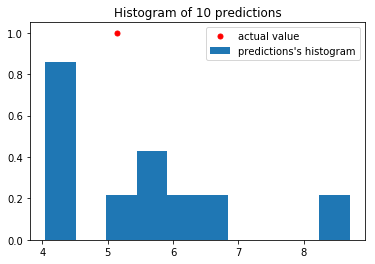

In [6]:
%matplotlib inline
import matplotlib.pyplot as plt

# Plot a histogram of the samples.
plt.subplot(111)
plt.hist(p.pred_all, bins=10, density=True, label = "predictions's histogram")
plt.plot(p.val, 1., 'ro', markersize =5, label = 'actual value')
plt.legend()
plt.title('Histogram of ' + str(len(p.pred_all)) + ' predictions')
plt.show()

### Accessing the saved model itself

The latents matrices for all samples are stored in the `PredictSession` as `numpy` arrays

In [7]:
# print the U matrices for the last sampling step
print([ u.shape for u in predictor.steps[-1].Us ])

[(16, 15073), (16, 346)]


### Making predictions from saved run

One can also make a `PredictSession` from a save root ini-file:

In [8]:
import smurff

predictor = smurff.PredictSession.fromRootFile("ic50-macau-save-root.ini")
print(predictor)

PredictSession with 10 samples
  Data shape = [15073, 346]
  Beta shape = [105672, 0]
  Num latent = 16
